<a href="https://colab.research.google.com/github/ThomasKarabo/Python-Data-Science/blob/main/Loan_Status_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [24]:
def wrangle(file_path):
  df = pd.read_csv(file_path)

  # Set the id column as the index
  df = df.set_index('loan_id')

  # Fix the column strings
  df.columns = df.columns.str.strip()
  return df

In [25]:
df = wrangle('/content/loan_approval_dataset.csv')

In [26]:
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
loan_id,,,,,,,,,,,,
1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4269 entries, 1 to 4269
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 433.6+ KB


## Split the Data into training, validation and testing

In [28]:
target = 'loan_status'
X = df.drop(columns = target)
y = df[target]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3415, 11), (854, 11), (3415,), (854,))

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2732, 11), (683, 11), (2732,), (683,))

## Model building

In [37]:
acc_baseline = df['loan_status'].value_counts(normalize=True).max()
acc_baseline

0.622159756383228

In [47]:
model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

In [48]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

## Model Evaluation

In [49]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)

print('Training Accuracy:', acc_train)
print('Validation Accuracy:', acc_val)

Training Accuracy: 1.0
Validation Accuracy: 0.8374816983894583


In [58]:
depth_hyperparams = range(1, 50, 2)

In [60]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    RandomForestClassifier(max_depth= d, n_jobs = -1, random_state = 42)
)
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6281112737920937, 0.6281112737920937, 0.6281112737920937]
Validation Accuracy Scores: [0.5915080527086384, 0.5915080527086384, 0.5915080527086384]


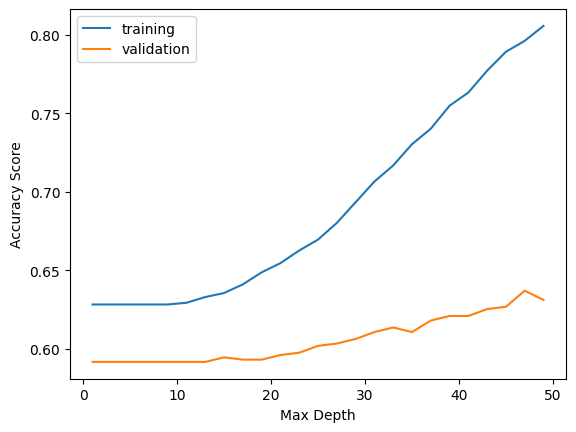

In [61]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label='training')
plt.plot(depth_hyperparams, validation_acc, label='validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend();

In [66]:
clf = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    GradientBoostingClassifier()
)

In [76]:
params = {
    'gradientboostingclassifier__n_estimators': range(25,100,25),
    'gradientboostingclassifier__max_depth': range(1,7)
}

In [77]:
model_gb = GridSearchCV(
    clf,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

In [78]:
model_gb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(1, 7),
                         'gradientboostingclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [92]:
results = pd.DataFrame(model_gb.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,1.201907,0.097293,0.018121,0.011938,6,75,"{'gradientboostingclassifier__max_depth': 6, '...",0.722121,0.702011,0.710623,0.719780,0.725275,0.715962,0.008513,1
14,1.624192,0.247227,0.024922,0.002765,5,75,"{'gradientboostingclassifier__max_depth': 5, '...",0.711152,0.691042,0.701465,0.699634,0.697802,0.700219,0.006504,2
16,0.839052,0.009298,0.012421,0.000382,6,50,"{'gradientboostingclassifier__max_depth': 6, '...",0.692870,0.674589,0.684982,0.679487,0.683150,0.683016,0.006074,3
11,0.895055,0.015001,0.013927,0.000546,4,75,"{'gradientboostingclassifier__max_depth': 4, '...",0.685558,0.674589,0.684982,0.673993,0.684982,0.680820,0.005339,4
13,0.717249,0.010059,0.012805,0.000638,5,50,"{'gradientboostingclassifier__max_depth': 5, '...",0.676417,0.672761,0.683150,0.664835,0.673993,0.674231,0.005913,5
8,0.676843,0.035967,0.012736,0.000540,3,75,"{'gradientboostingclassifier__max_depth': 3, '...",0.674589,0.674589,0.675824,0.663004,0.672161,0.672033,0.004669,6
10,0.610883,0.015486,0.014194,0.001152,4,50,"{'gradientboostingclassifier__max_depth': 4, '...",0.674589,0.667276,0.663004,0.659341,0.653846,0.663611,0.007041,7
5,0.807957,0.107843,0.020917,0.009614,2,75,"{'gradientboostingclassifier__max_depth': 2, '...",0.661792,0.659963,0.655678,0.648352,0.639194,0.652996,0.008309,8
7,0.806433,0.130947,0.019812,0.006288,3,50,"{'gradientboostingclassifier__max_depth': 3, '...",0.658135,0.661792,0.648352,0.655678,0.635531,0.651897,0.009290,9
15,0.781563,0.126999,0.021042,0.008343,6,25,"{'gradientboostingclassifier__max_depth': 6, '...",0.645338,0.661792,0.644689,0.648352,0.646520,0.649338,0.006350,10


In [94]:
best_params = model_gb.best_params_
best_params

{'gradientboostingclassifier__max_depth': 6,
 'gradientboostingclassifier__n_estimators': 75}

In [97]:
acc_train = model_gb.score(X_train, y_train)
acc_val = model_gb.score(X_val, y_val)
acc_test = model_gb.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 3))
print("Validation Accuracy:", round(acc_val, 3))
print("Validation Accuracy:", round(acc_test, 3))

Training Accuracy: 0.792
Validation Accuracy: 0.71
Validation Accuracy: 0.727


In [116]:
with open('Loan Status Prediction', 'wb') as f:
    pickle.dump(model_gb, f)